# Regression Used Cars Dataset

https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data 


#### **Dependency**

In [1]:
#! pip install lightgbm

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from itertools import combinations  # For creating combinations of elements
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import lightgbm as lgb 
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn import preprocessing
import re
from sklearn.preprocessing import StandardScaler

#### **Utility Function**

In [2]:
def reduce_mem_usage(df, verbose=0):
    """
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    # Calculate the initial memory usage of the DataFrame
    start_mem = df.memory_usage().sum() / 1024**2

    # 🔄 Iterate through each column in the DataFrame
    for col in df.columns:
        col_type = df[col].dtype
        # Check if the column's data type is not 'object' (i.e., numeric)
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            # Check if the column's data type is an integer
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif str(col_type)[:5] == "float":
                # Check if the column's data type is a float
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)
    # ℹ️ Provide memory optimization information if 'verbose' is True
    if verbose:
        print(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        print(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        print(f"Decreased by {decrease:.2f}%")

    # Return the DataFrame with optimized memory usage
    return df

#### **Load Data**

load csv inside data folder

In [3]:
df = pd.read_csv("./data/vehicles.csv")
df=df.convert_dtypes()
df=reduce_mem_usage(df,verbose=True)
df.shape
df[0:4]

Memory usage of dataframe is 87.53 MB
Memory usage after optimization is: 87.53 MB
Decreased by 0.00%


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,az,<NA>,<NA>,<NA>
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,ar,<NA>,<NA>,<NA>
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,fl,<NA>,<NA>,<NA>
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,ma,<NA>,<NA>,<NA>


In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  Int64  
 1   url           426880 non-null  string 
 2   region        426880 non-null  string 
 3   region_url    426880 non-null  string 
 4   price         426880 non-null  Int64  
 5   year          425675 non-null  Int64  
 6   manufacturer  409234 non-null  string 
 7   model         421603 non-null  string 
 8   condition     252776 non-null  string 
 9   cylinders     249202 non-null  string 
 10  fuel          423867 non-null  string 
 11  odometer      422480 non-null  Int64  
 12  title_status  418638 non-null  string 
 13  transmission  424324 non-null  string 
 14  VIN           265838 non-null  string 
 15  drive         296313 non-null  string 
 16  size          120519 non-null  string 
 17  type          334022 non-null  string 
 18  pain

In [5]:
df[(df['manufacturer']=="ford")]['model'].unique()

<StringArray>
[                  'f-150 xlt',  'ranger supercrew xl pickup',
 'f150 super cab xl pickup 4d',      'f150 supercrew cab xlt',
   'ranger supercab xl pickup',             'f250 super duty',
  'f150 regular cab xl pickup',          'mustang gt premium',
                        'f450',        'expedition xlt sport',
 ...
     'e450 super duty cutaway',   'e-series chassis e-350 sd',
              'f15o fx4 sport',              'f-150 heritage',
         'ranger pickup truck',                  'ranger rmt',
        'f250 crew cab diesel',             'taurus wagon lx',
                   'f150, xlt',              'f150, platinum']
Length: 3875, dtype: string

#### **Split dataset** 

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2)
print(df_train.shape, df_test.shape)

(341504, 26) (85376, 26)


#### **Data Function**

data preperation

feature engineering

In [7]:
def data_preparation(df:pd.DataFrame)->pd.DataFrame:
    """"
    make data valid
    """
    def keep_first_word(s):
        if pd.notnull(s):  # Use pd.notnull instead of not pd.isnull
            s = str(s).lower()
            s=s.split()[0]
            s = re.sub('[^a-zA-Z0-9]', '', s)
            if(len(s)<3):
                return np.nan
            else:
                return s
        else:
            return np.nan  # Return np.nan for null values

        #Remove meaningless columns
    df.drop(['id','url','region','region_url','title_status',
         'image_url','VIN','size','county','description',
         'state','lat','long'], 
        axis=1, inplace=True)

    df = df.dropna(subset=['year', 'odometer', 'manufacturer', 'model'])
    df = df.fillna('unknown')

    # remove oultier 
    price_percentile25 = df['price'].quantile(0.25)
    price_percentile75 = df['price'].quantile(0.75)
    price_iqr = price_percentile75 - price_percentile25
    price_upper_limit = price_percentile75 + 1.5 * price_iqr
    price_lower_limit = df['price'].quantile(0.15)
    df = df[(df['price'] < price_upper_limit) & (df['price'] > price_lower_limit)]


    odometer_percentile75 = df['odometer'].quantile(0.75)
    odometer_percentile25 = df['odometer'].quantile(0.25)
    odometer_iqr = odometer_percentile75 - odometer_percentile25
    odometer_upper_limit = odometer_percentile75 + 1.5 * odometer_iqr
    odometer_lower_limit = df['odometer'].quantile(0.05)
    df = df[(df['odometer'] < odometer_upper_limit) & (df['odometer'] > odometer_lower_limit)]

    # process model col
    df['model'] = df['model'].apply(keep_first_word)
    df['model'] = df['model'].fillna("unknown")
    md = df['model'].value_counts()
    df['model'] = df['model'].apply(lambda s: str(s) if str(s) in md[:50] else "unknown")

    mf = df['manufacturer'].value_counts()
    df['manufacturer'] = df['manufacturer'].apply(lambda s: str(s) if str(s) in mf[:20] else "others")

    df['condition'] = df['condition'].fillna("unknown")

    # fill data from real world !!!!!!
    temp = df.loc[(df['manufacturer']=="ford") & (df['model']=="f150")]
    df.loc[temp.index, "cylinders"]=df.loc[(df['manufacturer']=="ford") & (df['model']=="f150"), "cylinders"].fillna("6 cylinders")
    df['cylinders'] = df['cylinders'].fillna("others")


    # clean the odometer data by computing averge between 0.05 and 0.95
    o1 = df['odometer'].quantile(0.95)
    o2 = df['odometer'].quantile(0.05)
    odometer_avg= df[(df['odometer']<o1) & (df['odometer']>o2)]['odometer'].mean()
    df['odometer'] = df['odometer'].fillna(int(odometer_avg))
    

    df = df.dropna(subset=['year'])
    df = df.drop_duplicates()

    # turn nominal data into number
    y = df['price']
    x =df.drop(columns=['price'])
    x=x.convert_dtypes()

    return x,y

def feature_engineering(df:pd.DataFrame)->pd.DataFrame:
    """"
    select useful feature
    """
    #vehicle_age=posting_year - year, get the usage time of this vehicle
    df["posting_date"] = pd.to_datetime(df["posting_date"], utc=True)
    df["posting_year"] = df["posting_date"].dt.year
    df["vehicle_age"] = df["posting_year"] - df["year"]
    
    df.drop(['posting_date','posting_year'], 
        axis=1, inplace=True)
    
    return df


def data_preprocessing(df:pd.DataFrame)->pd.DataFrame:
    x , y =data_preparation(df)
    x=feature_engineering(x)
    return x,y



In [8]:
df_train_x,df_train_y = data_preprocessing(df_train)
df_test_x, df_test_y = data_preprocessing(df_test)

print(df_train_x.isna().sum())
print(df['type'].unique())
print(df_train_x.shape, df_train_y.shape)

year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
transmission    0
drive           0
type            0
paint_color     0
vehicle_age     0
dtype: int64
<StringArray>
[         <NA>,      'pickup',       'truck',       'other',       'coupe',
         'SUV',   'hatchback',    'mini-van',       'sedan',     'offroad',
         'bus',         'van', 'convertible',       'wagon']
Length: 14, dtype: string
(250467, 12) (250467,)


In [9]:
df_train_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250467 entries, 367819 to 168458
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   year          250467 non-null  Int64 
 1   manufacturer  250467 non-null  string
 2   model         250467 non-null  string
 3   condition     250467 non-null  string
 4   cylinders     250467 non-null  string
 5   fuel          250467 non-null  string
 6   odometer      250467 non-null  Int64 
 7   transmission  250467 non-null  string
 8   drive         250467 non-null  string
 9   type          250467 non-null  string
 10  paint_color   250467 non-null  string
 11  vehicle_age   250467 non-null  Int64 
dtypes: Int64(3), string(9)
memory usage: 25.6 MB


In [10]:
temppd = pd.concat([df_train_x, df_train_x],ignore_index=True)
temppd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500934 entries, 0 to 500933
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   year          500934 non-null  Int64 
 1   manufacturer  500934 non-null  string
 2   model         500934 non-null  string
 3   condition     500934 non-null  string
 4   cylinders     500934 non-null  string
 5   fuel          500934 non-null  string
 6   odometer      500934 non-null  Int64 
 7   transmission  500934 non-null  string
 8   drive         500934 non-null  string
 9   type          500934 non-null  string
 10  paint_color   500934 non-null  string
 11  vehicle_age   500934 non-null  Int64 
dtypes: Int64(3), string(9)
memory usage: 47.3 MB


In [11]:
df_train_x['model'].unique()

<StringArray>
[   'unknown',    'outback',      'rogue',       '1500', 'expedition',
       '2500',    'transit',     'escape',  'silverado',      'super',
       'f350',       'f150',      'camry',     'accord',     'altima',
      'tahoe',     'sierra',       'f250',   'explorer',    'equinox',
    'odyssey',      'focus',      'yukon',     'tacoma',   'wrangler',
     'malibu',        'crv',     'fusion',      'grand',    'mustang',
     'sonata',    'corolla',    'elantra',      'civic',      'cruze',
     'impala',       'edge',    'charger',      'prius',   'corvette',
      'jetta',       'rav4',   'colorado',    '4runner',       'benz',
        'mdx',     'camaro',     'tundra',       '3500',   'forester']
Length: 50, dtype: string

In [12]:
#construct label encoder

def encode(categorical_cols,learn_df,df1,df2):
    for col in categorical_cols:
        le = preprocessing.LabelEncoder()
        print(f"Labeling of {col} col")
        learn_df[col]=le.fit_transform(learn_df[col])
        df1[col] = le.transform(df1[col])
        df2[col] = le.transform(df2[col])
    return learn_df,df1, df2

def scale(learn_df,df1,df2):
    cols =learn_df.columns.values.tolist()

    scaler = StandardScaler().set_output(transform="pandas")
    scaler.fit(learn_df)
    df1 = scaler.transform(df1)
    df2 = scaler.transform(df2)
    return df1, df2

cols = df_test_x.columns.values.tolist()
categorical_cols = []
for col in cols:
    if df_test_x[col].dtype == "string":
        categorical_cols.append(col)

print(f"{categorical_cols}")
# get the encoder 
tempPd = pd.concat([df_train_x,df_test_x],ignore_index=True)
tempPd,df_train_x,df_test_x = encode(categorical_cols,tempPd,df_train_x, df_test_x)
df_train_x,df_test_x = scale(tempPd,df_train_x, df_test_x)
#convert
del tempPd

['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'transmission', 'drive', 'type', 'paint_color']
Labeling of manufacturer col
Labeling of model col
Labeling of condition col
Labeling of cylinders col
Labeling of fuel col
Labeling of transmission col
Labeling of drive col
Labeling of type col
Labeling of paint_color col


In [13]:
df_train_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250467 entries, 367819 to 168458
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          250467 non-null  float64
 1   manufacturer  250467 non-null  float64
 2   model         250467 non-null  float64
 3   condition     250467 non-null  float64
 4   cylinders     250467 non-null  float64
 5   fuel          250467 non-null  float64
 6   odometer      250467 non-null  float64
 7   transmission  250467 non-null  float64
 8   drive         250467 non-null  float64
 9   type          250467 non-null  float64
 10  paint_color   250467 non-null  float64
 11  vehicle_age   250467 non-null  float64
dtypes: float64(12)
memory usage: 24.8 MB


In [14]:
df_test_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62748 entries, 266523 to 58290
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          62748 non-null  float64
 1   manufacturer  62748 non-null  float64
 2   model         62748 non-null  float64
 3   condition     62748 non-null  float64
 4   cylinders     62748 non-null  float64
 5   fuel          62748 non-null  float64
 6   odometer      62748 non-null  float64
 7   transmission  62748 non-null  float64
 8   drive         62748 non-null  float64
 9   type          62748 non-null  float64
 10  paint_color   62748 non-null  float64
 11  vehicle_age   62748 non-null  float64
dtypes: float64(12)
memory usage: 6.2 MB


#### **Training and Evaluation**

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 125233, number of used features: 12
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (1.43 MB) transferred to GPU in 0.002886 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 15995.000000
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 125234, number of used features: 12
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have bee

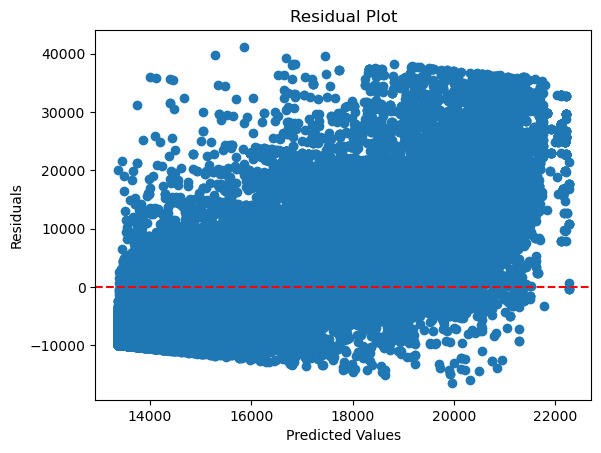

In [15]:
# training
numJobs=1
cv=2
paramgrid={
                "n_estimators": [300],
                "num_leaves": [256],
                "subsample": [1],
                "colsample_bytree":[0.8],
                "learning_rate": [0.001],
            }

model = lgb.LGBMRegressor(n_estimators= 500,random_state=4487,objective='mae',learning_rate=0.05,importance_type= "gain",device="gpu")
modelCV= GridSearchCV(model,param_grid=paramgrid,n_jobs=numJobs,verbose=True,cv=cv)
modelCV.fit(df_train_x, df_train_y)

#predict
y_pred = modelCV.predict(df_test_x)

#evaluation

# RMSE
rmse = np.sqrt(mean_squared_error(df_test_y, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# MAE
mae = mean_absolute_error(df_test_y, y_pred)
print(f"Mean Absolute Error: {mae}")

# R2
r2 = r2_score(df_test_y, y_pred)
print(f"R-squared: {r2}")

#Residual Analysis: 
residuals = df_test_y - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()